# How to remove common systematics using basis vectors (CBVs)

Cotrending Basis Vectors are used to remove long term trends in light curves. They are built from the most common trends observed in each channel. You can read more about CBVs in [Demystifying Kepler Data](https://arxiv.org/pdf/1207.3093.pdf). They can be used to clean lightcurves of common trends experience by all targets.

Below is an example workflow to remove CBVs from an light curve in Kepler; [Tabby's star](https://en.wikipedia.org/wiki/KIC_8462852).

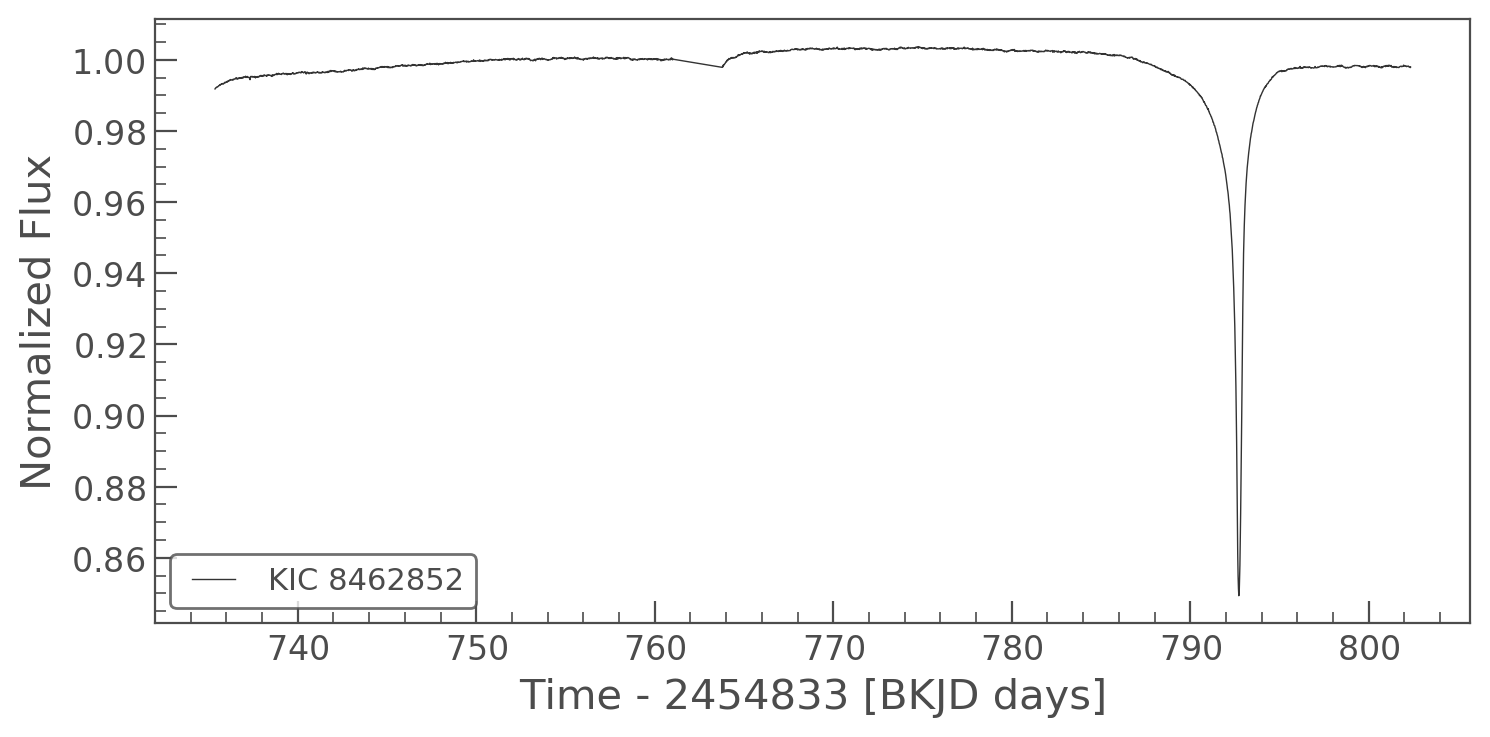

In [1]:
from lightkurve import search_lightcurvefile
lcf = search_lightcurvefile('KIC 8462852', quarter=8).download()
lc = lcf.SAP_FLUX 

#Remove nans and outliers
lc = lc.remove_nans()

%matplotlib inline
lc.plot(linestyle='-');

The light curve above has a significant dip due to the astrophysical variability from Tabby's star. However there are other long term trends and small ramps due to heating in the spacecraft, which we would like to remove. We can use CBV's to do this. Let's import the CBV corrector from `lightkurve`.

In [2]:
from lightkurve.correctors import KeplerCBVCorrector

We can use the `plot_cbvs` function to take a look at the trends we are going to remove. Let's look at just the first 8 trends.

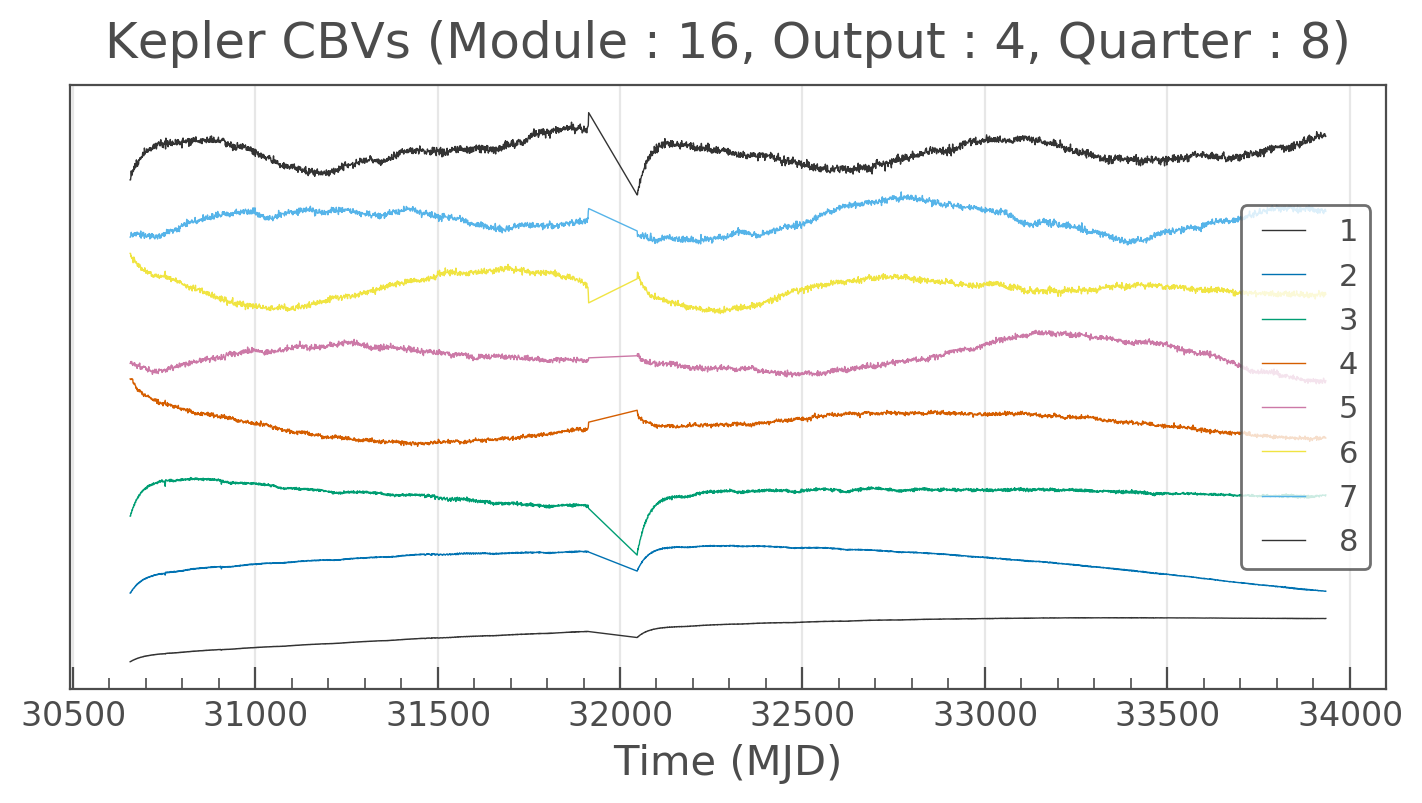

In [3]:
KeplerCBVCorrector(lcf).plot_cbvs([1,2,3,4,5,6,7,8]);

We probably don't want to correct all these trends out of Tabby's star. Let's pick just the first 5.

In [4]:
corr_lc =  KeplerCBVCorrector(lcf).correct(cbvs=[1,2,3,4,5])

In [5]:
corr_lc

KeplerLightCurve(ID: 8462852)

We can plot the two light curves on the same plot window to see the difference.

In [ ]:
ax = lc.plot(color='C3', label='SAP Flux', linestyle='-')
corr_lc.plot(ax=ax, color='C2', label='CBV Corrected SAP Flux', linestyle='-');

Now the CBVs have been corrected only the astrophysical variability is left, the variability from spacecraft heating has been removed.